# Inspect SegNet
This Jupyter notebook is used to generate segmentation predictions in order to inspect the results of a trained SegNet.
Check how to create an SHH tunnel to work remotely here: https://coderwall.com/p/ohk6cg/remote-access-to-ipython-notebooks-via-ssh

In [1]:
import sys
sys.path.insert(0, '../code')
import time
from models.segnet import build_segnet
import os
from tools.data_loader import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


We first need to define the dataset we are going to use, along with some useful information

In [2]:
# define the weights of the network
weights_file = "/home/master/experiments/master/Experiments/camvid/segnet_camvid_vgg/weights.hdf5"

if "camvid" in weights_file:
    color_map = {
        0: (128, 128, 128),    # sky
        1: (128, 0, 0),        # building
        2: (192, 192, 128),    # column_pole
        3: (128, 64, 128),     # road
        4: (0, 0, 192),        # sidewalk
        5: (128, 128, 0),      # Tree
        6: (192, 128, 128),    # SignSymbol
        7: (64, 64, 128),      # Fence
        8: (64, 0, 128),       # Car
        9: (64, 64, 0),        # Pedestrian
        10: (0, 128, 192),     # Bicyclist
        11: (0, 0, 0)          # Void
    }
    NUM_CLASSES = len(color_map.keys())-1 # it doesn't count the void class
    input_shape = (None, None, 3)
    path_to_images = "/home/master/experiments/Datasets/segmentation/camvid/valid/"
    void_class = [11]
    


And then we create the SegNet model and load the trained weights

In [3]:
model = build_segnet(input_shape, NUM_CLASSES, 0., None, basic=False)
model.load_weights(weights_file)

Prepare the images that we want to segment

In [4]:
test_dir = path_to_images+'images/'
imfiles = [os.path.join(test_dir,f) for f in os.listdir(test_dir) 
                                    if os.path.isfile(os.path.join(test_dir,f)) 
                                    and f.endswith('png')]

if len(imfiles) == 0:
    print "ERR: path_to_images do not contain any jpg file"

In [5]:
# convert ground truth (or predictions) to a color image given a color map:
def to_color(segmentation, color_map):
    lut = [] # look up table
    for item in color_map:
        lut.append(color_map[item])
    lut = np.array(lut)
    
    if len(segmentation.shape) == 3:
        segmentation = segmentation[:,:,0]
    
    res = lut[segmentation.astype(int)]
    
    return res.astype('uint8')

Load images and process them in batches

/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08125.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08155.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_07979.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_07999.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08129.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08101.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08143.png
/home/master/experiments/Datasets/segmentation/camvid/valid/images/0016E5_08063.png
8/8 [==============================] - 0s
8 images predicted in 0.52821 seconds. 15.14540 fps
Original image:


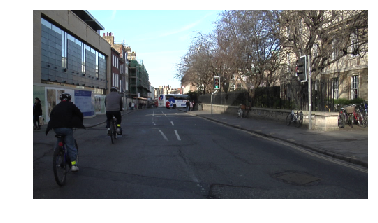

Image ground truth:


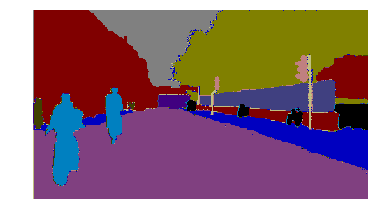

SegNet output:


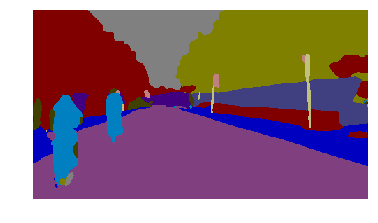

Original image:


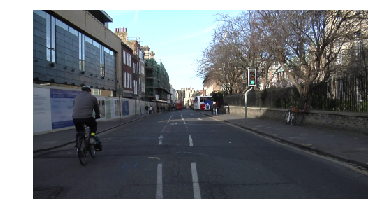

Image ground truth:


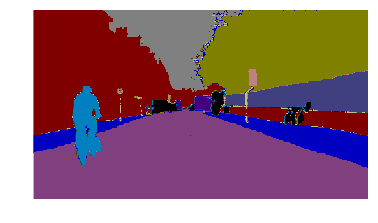

SegNet output:


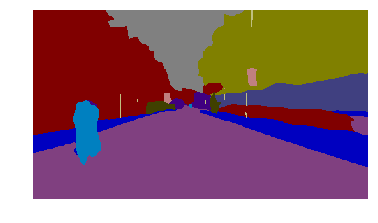

Original image:


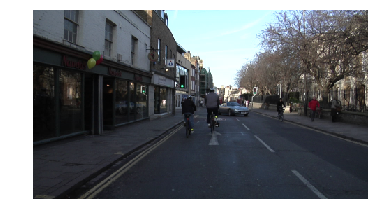

Image ground truth:


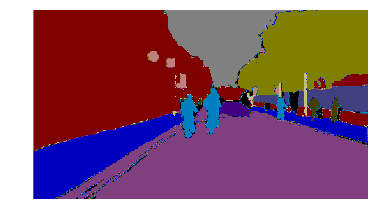

SegNet output:


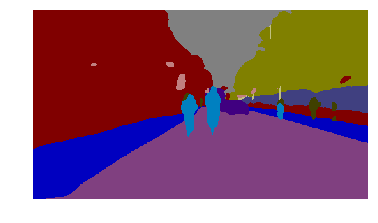

Original image:


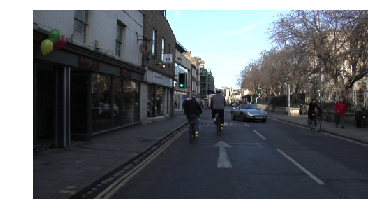

Image ground truth:


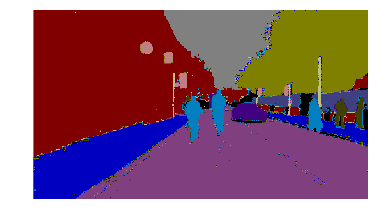

SegNet output:


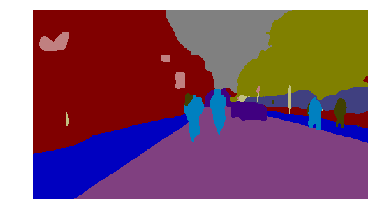

Original image:


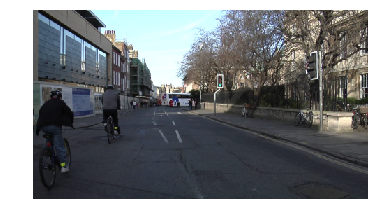

Image ground truth:


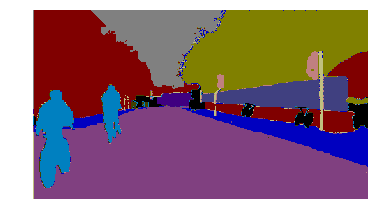

SegNet output:


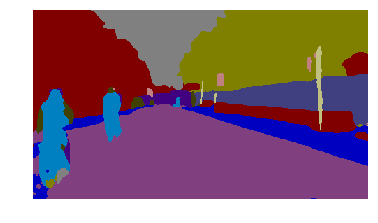

Original image:


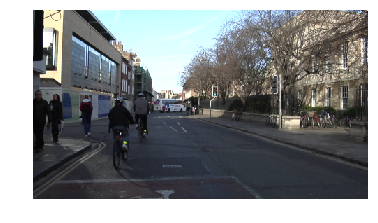

Image ground truth:


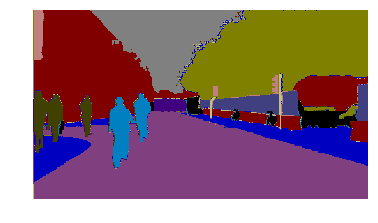

SegNet output:


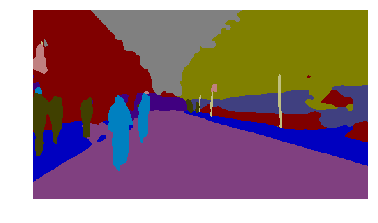

Original image:


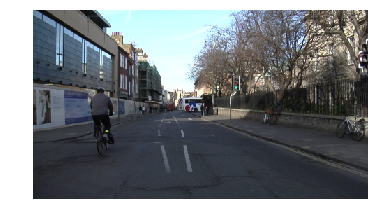

Image ground truth:


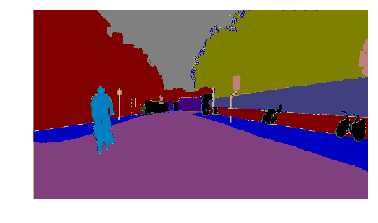

SegNet output:


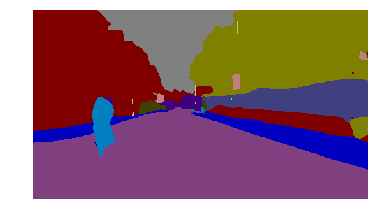

Original image:


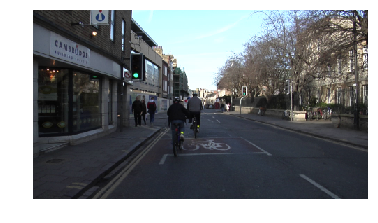

Image ground truth:


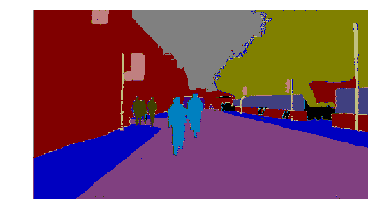

SegNet output:


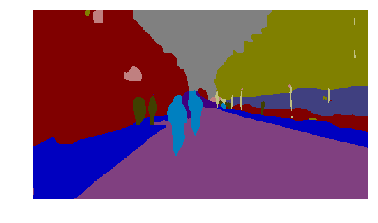

In [7]:
inputs = []
gts = [] # ground truth
chunk_size = min(8, len(imfiles)) # we are going to process all image files in chunks
rescale = 1/255.
resize = (270, 480)

for i, im_file in enumerate(imfiles):
    print(im_file)
    img = load_img(im_file, resize=resize)
    img = img_to_array(img)
    img *= rescale
    # load ground truth
    inputs.append(img.copy())
    gt = load_img(im_file.replace('/images/', '/masks/'), resize=resize)
    color_gt = to_color(gt, color_map)
    gts.append(color_gt)    
    
    if len(inputs)%chunk_size == 0 or i+1 == len(imfiles):
        inputs = np.array(inputs)
        start_time = time.time()
        net_out = model.predict(inputs, batch_size=8, verbose=1)
        print ('{} images predicted in {:.5f} seconds. {:.5f} fps').format(len(inputs),time.time() - start_time,(len(inputs)/(time.time() - start_time)))
        
        for j in range(net_out.shape[0]): # for each processed image
            img = inputs[j]
            gt = gts[j]
            out = net_out[j,...]
            color_out = to_color(out.argmax(axis=2), color_map)
            print('Original image:')
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            plt.figure()
            print('Image ground truth:')
            plt.imshow(gt)
            plt.axis('off')
            plt.show()
            plt.figure()
            print('SegNet output:')
            plt.imshow(color_out)
            plt.axis('off')
            plt.show()
            
            plt.close('all')
            #break
            
        inputs = []
        gts = []
        break # print only the first batch